<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/07-autoencoding-and-self-supervision/01_pca_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##PCA Autoencoder

In this notebook, we shows that bread-andbutter
principal component analysis (PCA) works by secretly being an autoencoder.

We’ll make small changes to a PyTorch version of PCA to change it into a fully fledged
autoencoding neural network. 

As we make an autoencoding network larger, it becomes
more important to constrain it well, which we demonstrate with the denoising strategy.

Finally we apply these concepts to sequential models like RNNs, which gives the autoregressive model.

##Setup

In [ ]:
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.metrics import accuracy_score

import time

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from idlmam import train_network, Flatten, View, weight_reset, set_seed

In [4]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Dataset

Now we want to create a wrapper for the MNIST datasets. 

Why? Because the default MNIST dataset will return data in pairs `(x, y)` for the input and label, respectively. 

But in our case, the input is the label because we are trying to predict the output from the input.

So we extend the PyTorch Dataset class to take the original tuple `x, y` and instead return a tuple `x, x`.

In [6]:
class AutoEncoderDataset(Dataset):
  """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs."""
  def __init__(self, dataset):
    self.dataset = dataset

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    x, y = self.dataset.__getitem__(idx)
    # just throw away the original label.
    return x, x

In [ ]:
B = 128

train_data = AutoEncoderDataset(torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data_xy = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncoderDataset(test_data_xy)

training_loader = DataLoader(train_data, batch_size=B, shuffle=True)
testing_loader = DataLoader(test_data_xx, batch_size=B)

##PCA encoder and decoder

Let’s define some basic hyperparameters.

In [8]:
D = 28 * 28       # input size
n = 2             # Hidden layer size
C= 1              # How many channels are in the input?
classes = 10      # How many classes are there?

Let's define `TransposeLinear` layer that will implement the Transpose
operation $W^T$. 

The matrix to transpose $W$ must be passed in as the `linear_layer` in the
constructor. 

This way, we can share weights between an original `nn.Linear` layer and
this transposed version of that layer.

In [9]:
class TransposeLinear(nn.Module):
  def __init__(self, linear_layer, bias=True):
    """
    linearLayer: is the layer that we want to use the transpose of to produce the output of this layer. 
                  So the Linear layer represents W, and this layer represents W^T. 
                  This is accomplished via weight sharing by re-using the weights of linearLayer
    bias: if True, we will crease a new bias term b that is learned separately from what is in linearLayer. 
          If false, we will not use any bias vector
    """
    super().__init__()

    # create a new variable weight to store a _reference_ to the original weight term.
    self.weight = linear_layer.weight

    if bias:
      # create a new bias vector
      self.bias = nn.Parameter(torch.Tensor(linear_layer.weight.shape[1]))
    else:
      # So if we want the bias term to exist, but be  potentially unused
      self.register_parameter("bias", None)

  def forward(self, x):
    # performs a linear transform when given an input (we use the transpose of our weights) and a bias (if None, it knows to not do anything)
    return F.linear(x, self.weight.t(), self.bias)

Note that because the input comes in as an image with shape `(B, 1, 28, 28)`, and we
are using linear layers, we first need to flatten the input into a vector of shape `(B, 28*28)`.

But in the decode step, we want to have the same shape as the original data.

In [10]:
# Since we will share the weights of the linear layer, lets define it separately
linear_layer = nn.Linear(D, n, bias=False)

# The encoder just falltens and then uses the linear layer
pca_encoder = nn.Sequential(
  nn.Flatten(),
  linear_layer
)

# The decoder uses our TransposeLinear layer + the now shared linearLayer object 
pca_decoder = nn.Sequential(
  TransposeLinear(linear_layer, bias=False),
  View(-1, 1, 28, 28)   # Shape the data back to it's original form
)

# Define a final PCA model that is the sequence of an encoder, followed by a decoder
pca_model = nn.Sequential(
  pca_encoder,
  pca_decoder
)

To make this autoencoder truly PCA, we
need to add the $WW^T = I$ constraint. 

This constraint has a name: **orthogonality**.

In [11]:
nn.init.orthogonal_(linear_layer.weight)

Parameter containing:
tensor([[-0.0063, -0.0112, -0.0474,  ...,  0.0428,  0.0234, -0.0159],
        [-0.0503,  0.0659, -0.0364,  ...,  0.0330,  0.0096,  0.0341]],
       requires_grad=True)

We take a common and simple
approach to encourage orthogonality.

This is done by converting the
equality $WW^T=I$ into a penalty or regularizer $||WW^T - I||_2^2$.

This works because if the
penalty is 0, then $W$ is orthogonal; and if the penalty is nonzero, it will increase the loss,
and thus gradient decent will try to make $W$ more orthogonal.

In [12]:
# Original loss function
mse_loss = nn.MSELoss()

# our PCA loss function
def mse_with_orthogonal_loss(x, y):
  # Grabing W from the linearLayer object
  W = linear_layer.weight
  # The identity matrix that is the target for the regularized
  I = torch.eye(W.shape[0]).to(device)
  # compute the original loss
  normal_loss = mse_loss(x, y)
  # compute the regularizer penalty 
  regularization_loss = 0.1 * mse_loss(torch.mm(W, W.t()), I)
  # return the sum of the two losses
  return normal_loss + regularization_loss

Now we can train this PCA model the same way we have been training other neural networks.

In [13]:
train_network(pca_model, mse_with_orthogonal_loss, training_loader, epochs=10, test_loader=testing_loader, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

,epoch,total time,train loss,test loss
0,0,8.291167,0.064485,0.058074
1,1,13.932068,0.058053,0.057870
2,2,19.645144,0.057895,0.057795
3,3,25.335907,0.057886,0.057814
4,4,30.910706,0.057886,0.057857
5,5,37.265668,0.057889,0.057818
6,6,44.371774,0.057888,0.057843
7,7,51.748565,0.057887,0.057811
8,8,58.035667,0.057886,0.057792
9,9,66.121422,0.057889,0.057857


###Visualizing PCA results

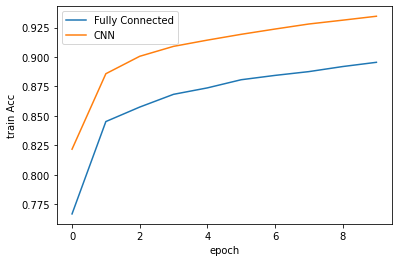

In [ ]:
sns.lineplot(x="epoch", y="train Acc", data=fc_results, label="Fully Connected")
sns.lineplot(x="epoch", y="train Acc", data=cnn_results, label="CNN")

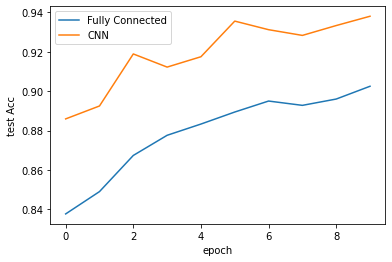

In [ ]:
sns.lineplot(x="epoch", y="test Acc", data=fc_results, label="Fully Connected")
sns.lineplot(x="epoch", y="test Acc", data=cnn_results, label="CNN")